In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# configure the GPU
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [14]:
input_dims = (256, 256, 3)

In [51]:
generator = ImageDataGenerator(
    rescale=1. / 255,
    # shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,
)

train_dataset = generator.flow_from_directory(
    "./datasets/potholes/train",
    target_size=input_dims[:2],
    batch_size=5,
    class_mode="binary",
    shuffle=True,
)

test_generator = ImageDataGenerator(rescale=1. / 255)
test_dataset = test_generator.flow_from_directory(
    "./datasets/potholes/test",
    target_size=input_dims[:2],
    batch_size=1,
    class_mode="binary",
    shuffle=True,
)

Found 1167 images belonging to 2 classes.
Found 226 images belonging to 2 classes.


In [56]:
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=input_dims),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid"),
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [84]:
class EarlyEndCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.85):
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        # if training accuracy goes above the threshold, stop training
        if logs["accuracy"] > self.threshold:
            print(f"\nTraining accuracy has reached the threshold of {self.threshold}")
            self.model.stop_training = True

In [87]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    callbacks=[EarlyEndCallback(threshold=0.9)],
)

Epoch 1/10
233/234 [============================>.] - ETA: 0s - loss: 0.2241 - accuracy: 0.9174
Training accuracy has reached the threshold of 0.9
234/234 [==============================] - 20s 82ms/step - loss: 0.2235 - accuracy: 0.9177 - val_loss: 0.1762 - val_accuracy: 0.9425


In [59]:
model.save("./models/potholes_small")

INFO:tensorflow:Assets written to: ./models/potholes_small\assets


In [23]:
from PIL import Image
import numpy as np
def load_image(path):
    im = Image.open(path)
    im = im.resize(input_dims[:2])
    
    im = np.array(im).astype("float32")
    im = im / 255.0
    im = np.expand_dims(im, axis=0)
    return im

In [28]:
import matplotlib.pyplot as plt
# resize the plt plot to 16, 16
plt.rcParams['figure.figsize'] = (8, 8)

In [38]:
def predict(path):
    image = load_image(path)
    prediction = model.predict(image)
    plt.imshow(image[0])

    return "pothole" if prediction[0][0] > 0.5 else "no pothole", prediction[0][0]

In [66]:
def validate(path, label):
    prediction, confidence = predict(path)
    print(f"Prediction: {prediction}")
    print(f"Confidence: {confidence}")
    if prediction == label:
        print("Correct!")
    else:
        print("Incorrect!")

<h1>Run from here for demonstration</h1>

**Note:**
Please download the required models from this link: [click me](https://drive.google.com/file/d/1-e9zJFZZQ0Ci8k576I_QWrPkZxEqRNde/view?usp=sharing) and extract it in the same folder as this notebook.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# configure the GPU
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [86]:
model = tf.keras.models.load_model("models/potholes_large")

Prediction: no pothole
Confidence: 0.42777377367019653
Correct!


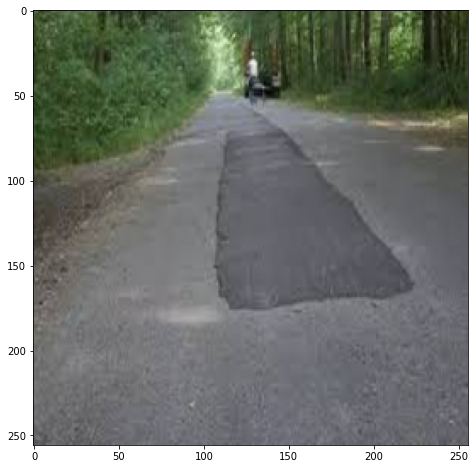

In [83]:
validate("./datasets/potholes/test/plain/3.jpg", "no pothole")